In [ ]:
!pip install numpy==1.26.4 
!pip install -U matplotlib
!pip install pandas
!pip install pyarrow
!pip install seaborn
!pip install tensorflow
!pip install scikit-learn

In [ ]:
import sys
sys.path.append('C:\\Users\\USER\\miniforge3\\envs\\LGPIC2408\\Lib\\site-packages\\numpy')

Import libraries

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

데이터 다운로드

데이터 전처리

In [40]:
df = pd.read_csv("dataset/jena_climate_2009_2016.csv")
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

In [41]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [42]:
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df=df.drop(['Tpot (K)','Tdew (degC)','VPmax (mbar)','VPact (mbar)','VPdef (mbar)','sh (g/kg)','H2OC (mmol/mol)','rho (g/m**3)','max. wv (m/s)','wd (deg)'], axis=1)
df = df[['p (mbar)', 'rh (%)', 'wv (m/s)','T (degC)' ]]

In [43]:
df.head()

,p (mbar),rh (%),wv (m/s),T (degC)
5,996.50,94.4,0.21,-8.05
11,996.62,93.2,0.25,-8.88
17,996.84,93.5,0.18,-8.81
23,996.99,92.6,0.10,-9.05
29,997.46,92.2,0.40,-9.63


In [44]:
df.describe()

,p (mbar),rh (%),wv (m/s),T (degC)
count,70091.000000,70091.000000,70091.000000,70091.000000
mean,989.212842,76.009788,1.702567,9.450482
std,8.358886,16.474920,65.447512,8.423384
min,913.600000,13.880000,-9999.000000,-22.760000
25%,984.200000,65.210000,0.990000,3.350000
50%,989.570000,79.300000,1.760000,9.410000
75%,994.720000,89.400000,2.860000,15.480000
max,1015.290000,100.000000,14.010000,37.280000


In [45]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

In [46]:
df.describe()

,p (mbar),rh (%),wv (m/s),T (degC)
count,70091.000000,70091.000000,70091.000000,70091.000000
mean,989.212842,76.009788,2.130539,9.450482
std,8.358886,16.474920,1.543098,8.423384
min,913.600000,13.880000,0.000000,-22.760000
25%,984.200000,65.210000,0.990000,3.350000
50%,989.570000,79.300000,1.760000,9.410000
75%,994.720000,89.400000,2.860000,15.480000
max,1015.290000,100.000000,14.010000,37.280000


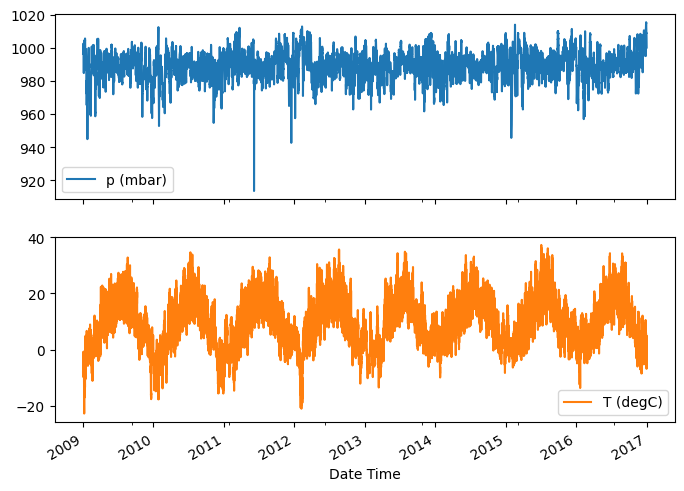

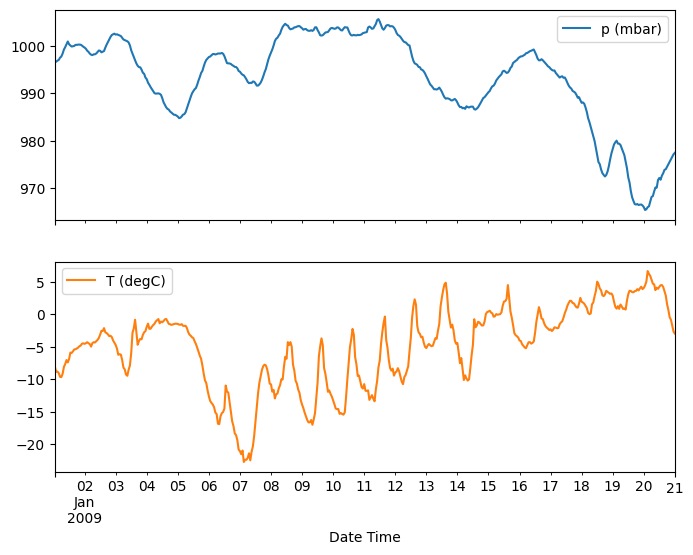

In [47]:
plot_cols = ['p (mbar)','T (degC)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

Train, test 데이터 분할

In [48]:
# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 7
batch = 100
train_size = int(len(df)*0.7)
train_set = df[0:train_size]
train_date_time=date_time[0:train_size]
test_set = df[train_size-seq_length:]
test_date_time=date_time[train_size-seq_length:]

In [49]:
train_set.head()

,p (mbar),rh (%),wv (m/s),T (degC)
5,996.50,94.4,0.21,-8.05
11,996.62,93.2,0.25,-8.88
17,996.84,93.5,0.18,-8.81
23,996.99,92.6,0.10,-9.05
29,997.46,92.2,0.40,-9.63


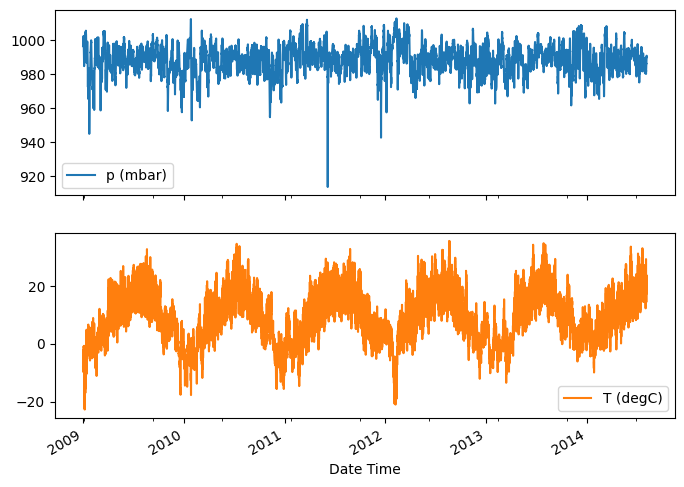

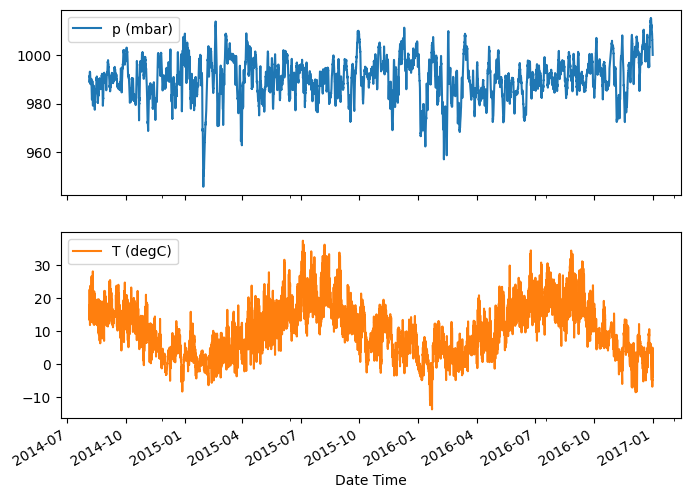

In [50]:
plot_cols = ['p (mbar)','T (degC)']
plot_features = train_set[plot_cols]
plot_features.index = train_date_time
_ = plot_features.plot(subplots=True)

plot_features = test_set[plot_cols]
plot_features.index = test_date_time
_ = plot_features.plot(subplots=True)

데이터 스케일링

In [51]:
# Input scale
scaler_x = MinMaxScaler()
scaler_x.fit(df.iloc[:, :-1])

train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])


# Output scale
scaler_y = MinMaxScaler()
scaler_y.fit(df.iloc[:, [-1]])

train_set.iloc[:, [-1]] = scaler_y.transform(train_set.iloc[:, [-1]])
test_set.iloc[:, [-1]] = scaler_y.transform(test_set.iloc[:, [-1]])

C:\Users\USER\AppData\Local\Temp\ipykernel_208\259724191.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.iloc[:, :-1] = scaler_x.transform(train_set.iloc[:, :-1])
C:\Users\USER\AppData\Local\Temp\ipykernel_208\259724191.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.iloc[:, :-1] = scaler_x.transform(test_set.iloc[:, :-1])
C:\Users\USER\AppData\Local\Temp\ipykernel_208\259724191.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [53]:
train_set.describe()

,p (mbar),rh (%),wv (m/s),T (degC)
count,49063.000000,49063.000000,49063.000000,49063.000000
mean,0.736702,0.720078,0.153755,0.530746
std,0.141850,0.192505,0.109556,0.144156
min,-8.976868,-0.151419,0.000000,0.000000
25%,0.688367,0.593590,0.072805,0.428714
50%,0.742551,0.758477,0.128480,0.532145
75%,0.791523,0.876916,0.206281,0.634577
max,0.975809,1.000000,1.000000,0.972851


In [15]:
print(test_set[0:5]) 
'''압력과 상대습도 값의 최소값이 -로 나오고 있습니다.
scaler_x.fit(train_set.iloc[:, [0]])
train_set.iloc[:,[0]] = scaler_x.transform(train_set.iloc[:,[0]])
위와 같이 1열씩 스케일러를 사용하면 문제가 없는 것으로 보아 3 열을 한번에 스케일링을 진행하며 오류가 발생한 것 같습니다.
하지만 스케일러를 하나하나 사용하면 코드가 너무 복잡해지므로 코드 진행에 큰 문제가 없다면 그대로 진행해도 문제 없을것 같습니다.
'''

        p (mbar)    rh (%)  wv (m/s)  T (degC)
294341 -9.199227 -0.151406  0.006674  0.401486
294347 -9.199200 -0.150894  0.002598  0.401378
294353 -9.199128 -0.150691  0.014775  0.401296
294359 -9.199046 -0.151419  0.013501  0.401231
294365 -9.199087 -0.150381  0.004585  0.400879


'압력과 상대습도 값의 최소값이 -로 나오고 있습니다.\nscaler_x.fit(train_set.iloc[:, [0]])\ntrain_set.iloc[:,[0]] = scaler_x.transform(train_set.iloc[:,[0]])\n위와 같이 1열씩 스케일러를 사용하면 문제가 없지만 코드 간소화를 위해 한번에 스케일링을 진행하며 오류가 발생한 것 같습니다.\n'

In [16]:
train_set.head()

,p (mbar),rh (%),wv (m/s),T (degC)
5,0.835433,0.934974,0.014989,0.251840
11,0.836642,0.921040,0.017844,0.237631
17,0.838859,0.924524,0.012848,0.238829
23,0.840371,0.914073,0.007138,0.234720
29,0.845107,0.909429,0.028551,0.224790


데이터셋 생성

In [17]:
device = torch.device('cpu')
# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)


# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

testX_tensor = testX_tensor.to(device)
testY_tensor = testY_tensor.to(device)
# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)
# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,
                        drop_last=True)

In [18]:
testX_tensor.shape

torch.Size([21028, 7, 4])

In [19]:
next(iter(dataloader))

[tensor([[[0.7786, 0.3862, 0.1499, 0.4854],
          [0.7858, 0.4361, 0.1991, 0.4857],
          [0.7912, 0.5621, 0.2855, 0.4869],
          ...,
          [0.7993, 0.6737, 0.1670, 0.4830],
          [0.8029, 0.6512, 0.1749, 0.4837],
          [0.8055, 0.6598, 0.0935, 0.4797]],
 
         [[0.7834, 0.6865, 0.0157, 0.6304],
          [0.7870, 0.7399, 0.0400, 0.6062],
          [0.7885, 0.8479, 0.0771, 0.5770],
          ...,
          [0.7902, 0.9268, 0.0328, 0.5470],
          [0.7925, 0.9385, 0.0500, 0.5253],
          [0.7929, 0.9524, 0.0393, 0.5146]],
 
         [[0.9063, 0.8386, 0.0985, 0.5263],
          [0.9111, 0.9187, 0.1049, 0.5133],
          [0.9174, 0.9419, 0.1056, 0.5114],
          ...,
          [0.9242, 0.9315, 0.0942, 0.5126],
          [0.9301, 0.9210, 0.0621, 0.5141],
          [0.9337, 0.9594, 0.0457, 0.5090]],
 
         ...,
 
         [[0.7578, 0.7364, 0.1442, 0.5574],
          [0.7633, 0.7422, 0.1363, 0.5554],
          [0.7658, 0.7283, 0.0799, 0.5609],
      

In [20]:
print(testX_tensor[0:2])

tensor([[[-9.1992e+00, -1.5141e-01,  6.6741e-03,  4.0149e-01],
         [-9.1992e+00, -1.5089e-01,  2.5983e-03,  4.0138e-01],
         [-9.1991e+00, -1.5069e-01,  1.4775e-02,  4.0130e-01],
         [-9.1990e+00, -1.5142e-01,  1.3501e-02,  4.0123e-01],
         [-9.1991e+00, -1.5038e-01,  4.5853e-03,  4.0088e-01],
         [-9.1991e+00, -1.5025e-01,  4.0249e-03,  4.0080e-01],
         [-9.1991e+00, -1.5018e-01,  5.1457e-03,  4.0066e-01]],

        [[-9.1992e+00, -1.5089e-01,  2.5983e-03,  4.0138e-01],
         [-9.1991e+00, -1.5069e-01,  1.4775e-02,  4.0130e-01],
         [-9.1990e+00, -1.5142e-01,  1.3501e-02,  4.0123e-01],
         [-9.1991e+00, -1.5038e-01,  4.5853e-03,  4.0088e-01],
         [-9.1991e+00, -1.5025e-01,  4.0249e-03,  4.0080e-01],
         [-9.1991e+00, -1.5018e-01,  5.1457e-03,  4.0066e-01],
         [ 7.7426e-01,  9.5239e-01,  1.0421e-01,  6.3722e-01]]])


LSTM

In [21]:
import torch.nn as nn

# 설정값
data_dim = 4
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
nb_epochs = 100

class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True)

    # 학습 초기화를 위한 함수
    def reset_hidden_state(self):
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))

    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

Training

In [22]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):

    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs

    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)

        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples

            # seq별 hidden state reset
            model.reset_hidden_state()

            # H(x) 계산
            outputs = model(x_train)

            # cost 계산
            loss = criterion(outputs, y_train)

            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost += loss/total_batch

        train_hist[epoch] = avg_cost

        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))

        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):

            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping : %04d epoch' %(epoch))

                break

    return model.eval(), train_hist

학습 시작

In [23]:
# 모델 학습
# 설정값
data_dim = 4 #이 부분은 input dimension 4(p (mbar),rh (%),wv (m/s),T (degC))가 맞습니다.
output_dim = 1
hidden_dim = 10
learning_rate = 0.01
nb_epochs =5
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1)
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose =1, patience = 10)

Epoch: 0000 train loss : 0.0027
Epoch: 0001 train loss : 0.0003
Epoch: 0002 train loss : 0.0002
Epoch: 0003 train loss : 0.0002
Epoch: 0004 train loss : 0.0002


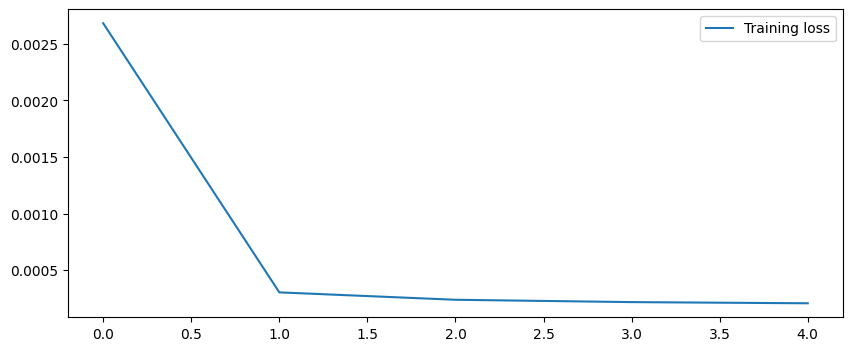

In [24]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [25]:
# # 모델 저장
# PATH ="model1/model1.pth"
# #torch.save(model.state_dict(), PATH)

# # 불러오기
# model = Net(data_dim, hidden_dim, seq_length, output_dim, 1)
# model.load_state_dict(torch.load(PATH), strict=False)
# model.eval()

모델 테스트

In [26]:
# 예측 테스트
a=100
testX_tensor_100=testX_tensor[a:a+100]
testY_tensor_100=testY_tensor[a:a+100]
with torch.no_grad():
    pred = []
    for pr in range(len(testX_tensor_100)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(testX_tensor_100[pr], 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler_y.inverse_transform(testY_tensor_100)


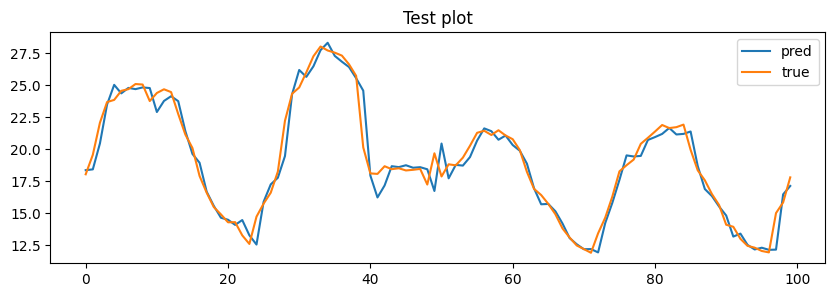

In [27]:
fig = plt.figure(figsize=(10,3))
plt.plot(np.arange(len(pred_inverse)), pred_inverse, label = 'pred')
plt.plot(np.arange(len(testY_inverse)), testY_inverse, label = 'true')
plt.title("Test plot")
plt.legend()
plt.show()